GPU
['TensorrtExecutionProvider', 'CUDAExecutionProvider', 'CPUExecutionProvider']
Current Working Directory: C:\Users\joeli\Dropbox\Code\Python Projects\Texture_Image_Pipeline\onnx_inference
Current Working Directory: C:\Users\joeli\Dropbox\Code\Python Projects\Texture_Image_Pipeline\torch_face
CUDAExecutionProvider available. Using GPU.
Loaded model from C:\Users\joeli\Dropbox\Code\Python Projects\Texture_Image_Pipeline\torch_face\79999_iter.pth
['C:\\Users\\joeli\\Dropbox\\Code\\Python Projects\\Texture_Image_Pipeline\\fitzpatrick\\ft_1_053411.png', 'C:\\Users\\joeli\\Dropbox\\Code\\Python Projects\\Texture_Image_Pipeline\\fitzpatrick\\ft_1_053412.png', 'C:\\Users\\joeli\\Dropbox\\Code\\Python Projects\\Texture_Image_Pipeline\\fitzpatrick\\ft_1_053415.png', 'C:\\Users\\joeli\\Dropbox\\Code\\Python Projects\\Texture_Image_Pipeline\\fitzpatrick\\ft_1_ft_1_053077.png', 'C:\\Users\\joeli\\Dropbox\\Code\\Python Projects\\Texture_Image_Pipeline\\fitzpatrick\\ft_2_ft_2_053021.png', 'C:\\Us

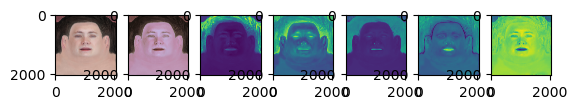

(1, 4194304, 3)
float32


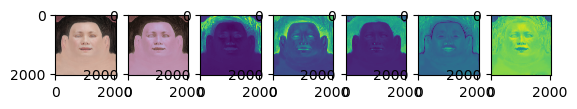

In [1]:
# !pip install onnxruntime
# !pip uninstall onnxruntime -y
# !pip install --user onnxruntime 
# !pip install --user onnxruntime-gpu

import numpy as np
import onnxruntime as ort
print(ort.get_device())
print(ort.get_available_providers())
import onnx_inference
from onnx_inference import onnx_ae 
import os
# from PIL import Image
import sys

import torch
import os
import os.path as osp
import numpy as np
from PIL import Image
import torchvision.transforms as transforms
import cv2
import matplotlib.pyplot as plt
import pickle
import importlib
import torch_face
from torch_face import face_part_segmentation as fps
# pip install Pillow opencv-python 

decoder_path = r"C:\Users\joeli\Dropbox\Code\Python Projects\Texture_Image_Pipeline\onnx_inference\no_duplicates_75_2_mask_decoder.onnx"
encoder_path = r"C:\Users\joeli\Dropbox\Code\Python Projects\Texture_Image_Pipeline\onnx_inference\no_duplicates_75_2_mask_encoder.onnx"
# C:\Users\joeli\Dropbox\Code\Python Projects\Texture_Image_Pipeline\onnx_inference\small_batch_size_encoder.onnx
# C:\Users\joeli\Dropbox\Code\Python Projects\Texture_Image_Pipeline\onnx_inference\small_batch_size_decoder.onnx
encoder_path = r"C:\Users\joeli\Dropbox\Code\Python Projects\Texture_Image_Pipeline\onnx_inference\small_batch_size_encoder.onnx"
decoder_path = r"C:\Users\joeli\Dropbox\Code\Python Projects\Texture_Image_Pipeline\onnx_inference\small_batch_size_decoder.onnx"
ae = onnx_ae.ONNXAutoencoder(encoder_path, decoder_path)
image_dir = r"C:\Users\joeli\Dropbox\Code\Python Projects\Texture_Image_Pipeline\fitzpatrick"
image_paths  =  os.listdir(image_dir)
image_paths = [os.path.join(image_dir, im) for im in image_paths]
segmenter = fps.FacePartSegmentation(width=2048, height=2048)
print(image_paths)
for im_path in image_paths[:2]:

    im = cv2.imread(im_path)
    im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
    im = cv2.resize(im, (2048, 2048))
    im = np.asarray(im).astype(np.float32).reshape(-1, 3)
    im = im/255.0
    encoded = ae.encode(im)
    pm = np.asarray(encoded).astype(np.float32).reshape(2048, 2048, 5)
    cm = pm[:,:,0]
    ch = pm[:,:,1]+0.5
    bm = pm[:,:,2]
    bh = pm[:,:,3]+0.2
    t = pm[:,:,4]
    pm = np.dstack((cm, ch, bm, bh, t))
    encoded = np.asarray(pm).astype(np.float32)
    encoded = encoded.reshape(-1, 5)
    decoded = ae.decode(encoded)
    print(np.asarray(decoded).shape)
    print(np.asarray(decoded).dtype)
    decoded = np.asarray(decoded).astype(np.float32).reshape(2048, 2048, 3)
    fig, ax = plt.subplots(1, 7)
    ax[0].imshow(im.reshape(2048, 2048, 3))
    ax[1].imshow(decoded)
    ax[2].imshow(cm)
    ax[3].imshow(ch)
    ax[4].imshow(bm)
    ax[5].imshow(bh)
    ax[6].imshow(t)
    plt.show()
    